<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898430 entries, 0 to 4898429
Data columns (total 42 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   duration                             int64  
 1   protocolType                         object 
 2   service                              object 
 3   flag                                 object 
 4   sourceByte                           int64  
 5   destinationByte                      int64  
 6   land                                 int64  
 7   wrongFragment                        int64  
 8   urgent                               int64  
 9   hot                                  int64  
 10  numberFailedLogins                   int64  
 11  loggedIn                             int64  
 12  numberCompromised                    int64  
 13  rootShell                            int64  
 14  suAttempted                          int64  
 15  numRoot                         

<Figure size 2000x4000 with 0 Axes>

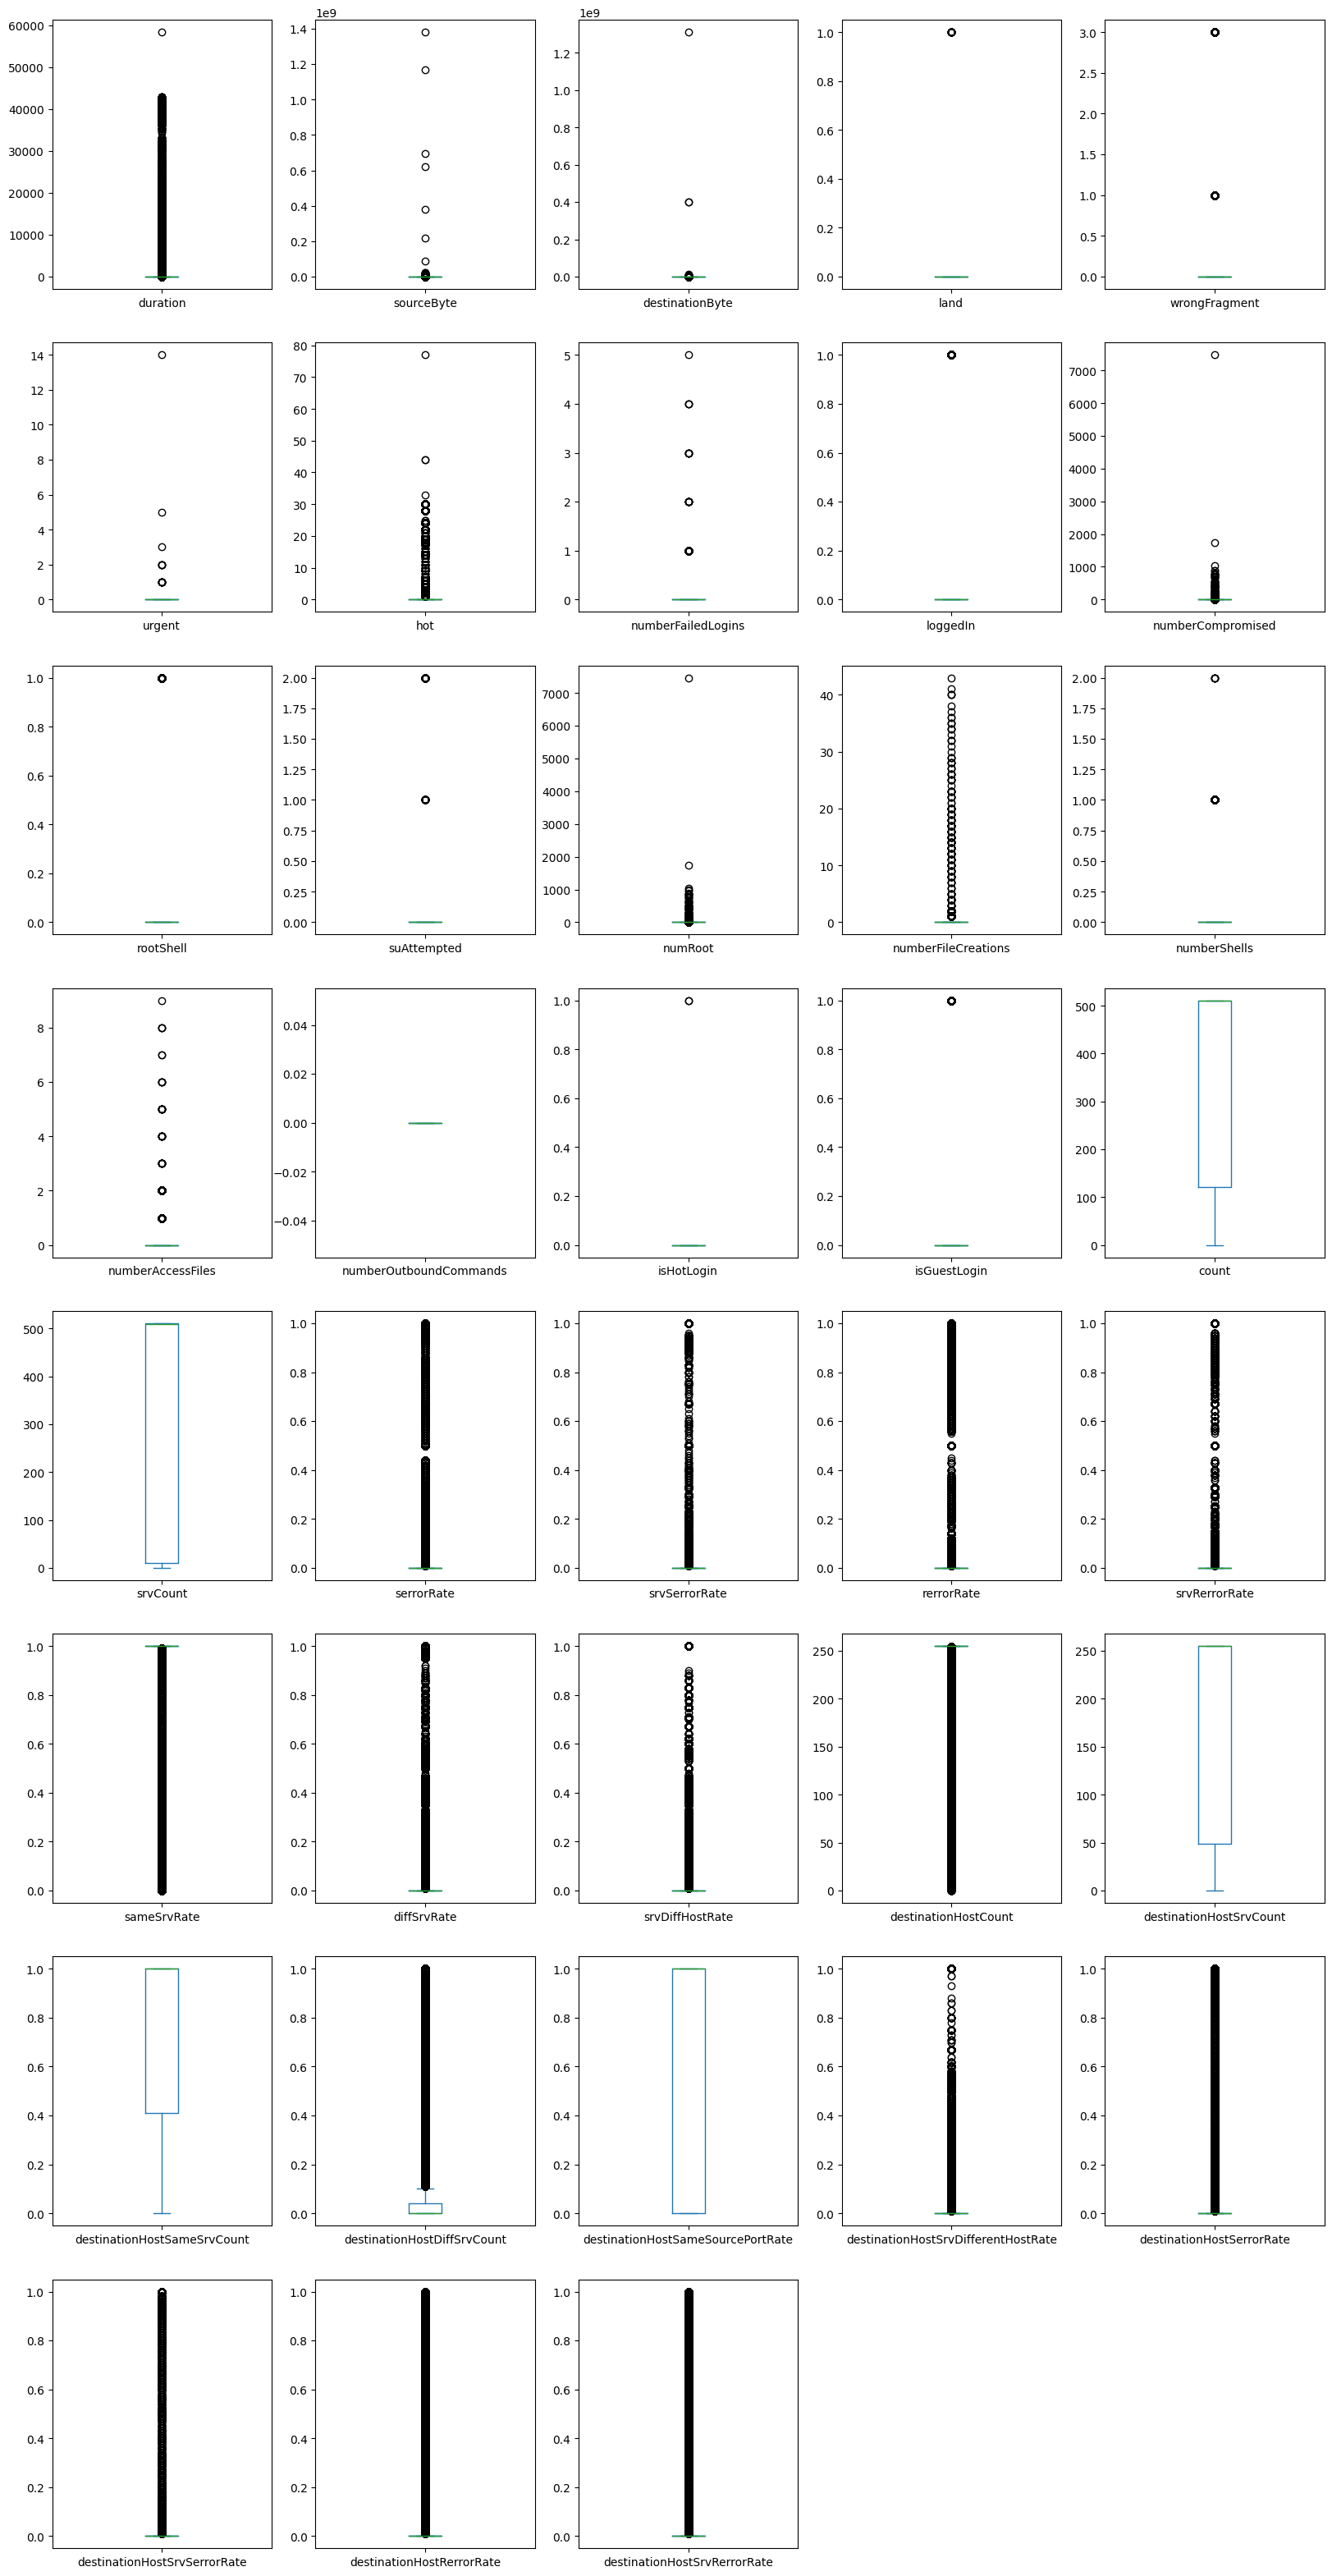

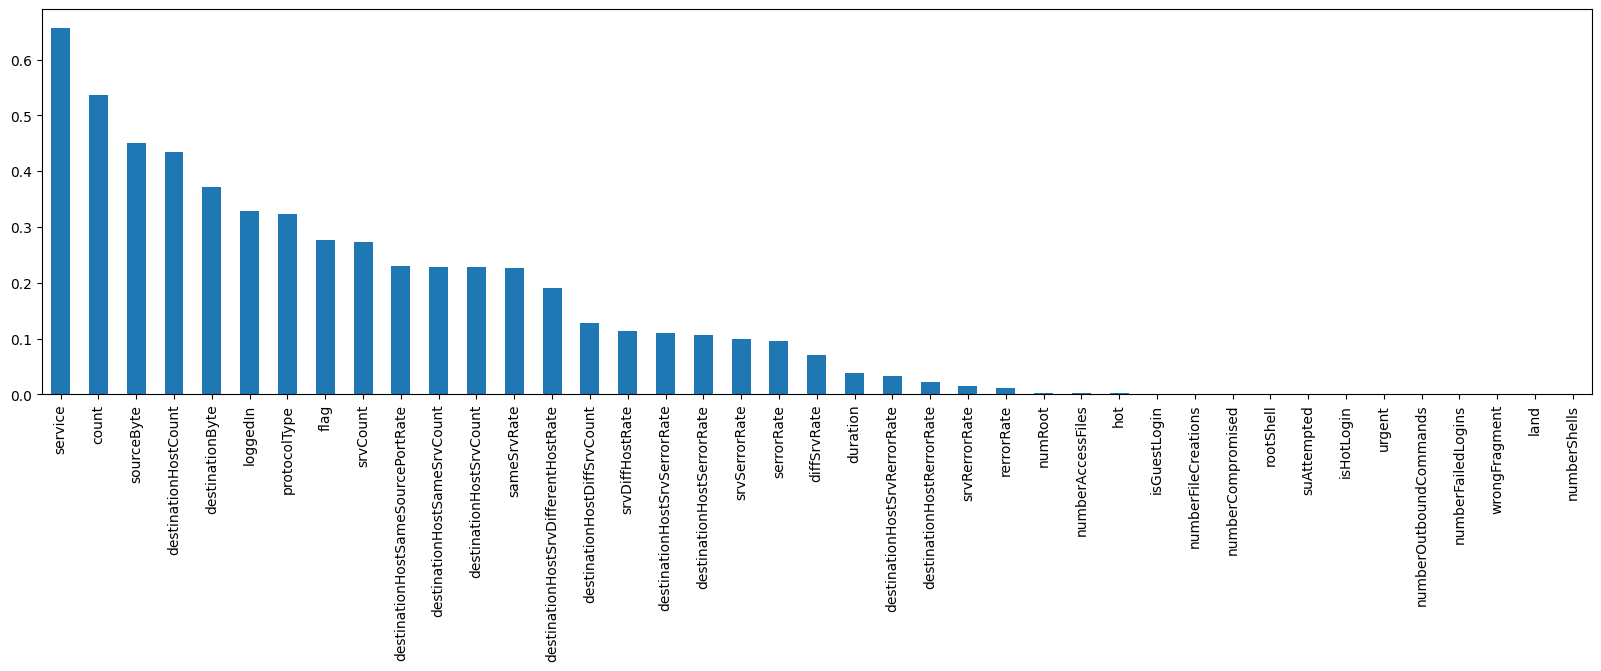

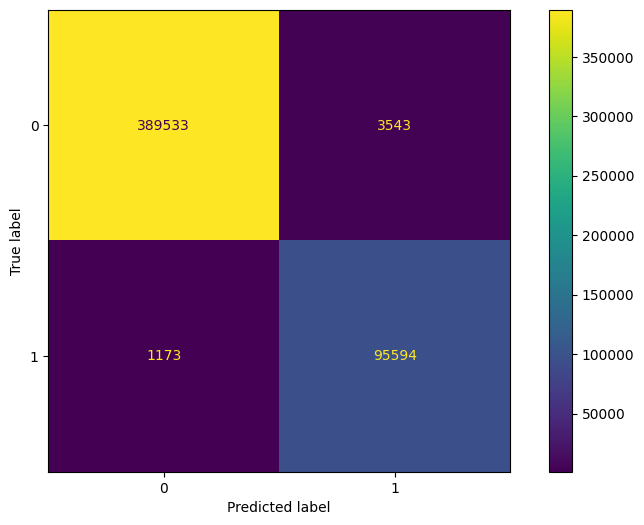

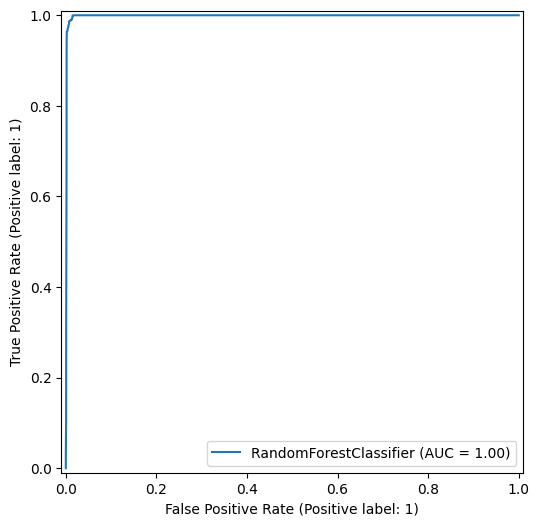

Test Set
[[389533   3543]
 [  1173  95594]]
              precision    recall  f1-score   support

           0   0.996998  0.990986  0.993983    393076
           1   0.964262  0.987878  0.975927     96767

    accuracy                       0.990372    489843
   macro avg   0.980630  0.989432  0.984955    489843
weighted avg   0.990531  0.990372  0.990416    489843


Train Set
[[3495948   36626]
 [   8298  867715]]
              precision    recall  f1-score   support

           0   0.997632  0.989632  0.993616   3532574
           1   0.959500  0.990528  0.974767    876013

    accuracy                       0.989810   4408587
   macro avg   0.978566  0.990080  0.984191   4408587
weighted avg   0.990055  0.989810  0.989870   4408587



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from time import time
warnings.filterwarnings ('ignore')

pd.set_option ('display.float_format', lambda x: '%.3f' % x)
plt.rcParams ["figure.figsize"] = (10,6) 

#READING DATASET & ADJSUTING COLUMNS
readTrainFile = pd.read_csv ('KDDCup99_full.txt')
organisedFile = readTrainFile.copy()
columns = (['duration' #Duration of connection in seconds
            ,'protocolType' #Protocol used for the connection (ICMP, UDP, TCP, etc.)
            ,'service' #Destination port that is mapped to a service (HTTP, FTP, HTTPS, etc.)
            ,'flag' #Normal or error status flag of connection (SF, S0 & REJ)
            ,'sourceByte' #Number of data, in bytes, from source to destination
            ,'destinationByte' #Number of data bytes from destination to source
            ,'land' #'1' represents if the connection is from/to the same host/port; else '0'
            ,'wrongFragment' #Number of 'wrong' fragments (values 0,1,3)
            ,'urgent' #Number of urgent packets
            ,'hot' #Number of 'hot' indicators (bro-ids feature)
            ,'numberFailedLogins' #Number of failed login attempts
            ,'loggedIn' #'1' indicates if sucessfully logged, else '0'
            ,'numberCompromised' #Number of 'compromised' conditions
            ,'rootShell' #'1' indicates if root shell is obtained, otherwise '0'
            ,'suAttempted' #'1' indicates if "Super User Root" command was attempted, otherwise '0'
            ,'numRoot' #Number of root acesses 
            ,'numberFileCreations' #Number of file creation operations
            ,'numberShells' #Number of shell prompts
            ,'numberAccessFiles' #Number of operations on the acess control files
            ,'numberOutboundCommands' #Number of outbound commands within an ftp session
            ,'isHotLogin' #'1' is the login belongs to a 'hot' list (e.g. root, admin); else 0
            ,'isGuestLogin' #'1' is if the login is a 'guest' login (e.g. guest, anonymous, etc.); else 0
            ,'count' #The number of connections to the same host as current connections in past two seconds
            ,'srvCount' #The number of connections tot he same service as the curent connection in the past two seconds
            ,'serrorRate' #The percetage(%) of connections that have 'SYN' errors
            ,'srvSerrorRate' #The percetage(%) of connections that have 'SYN' errors
            ,'rerrorRate' #The percetage(%) of connections that have 'REJ' errors
            ,'srvRerrorRate' #The percetage(%) of connections that have 'REJ' errors
            ,'sameSrvRate' #The percentage(%) of connections to the same services
            ,'diffSrvRate' #The percentage(%) of connections to different services
            ,'srvDiffHostRate' #The percentage(%) of connections to different hosts
            ,'destinationHostCount' #The count of the connections that have the same destination host
            ,'destinationHostSrvCount' #The count of the connections that have the same destination host and using the same service
            ,'destinationHostSameSrvCount' #The percentage(%) of connections having the same destination port and using the same service
            ,'destinationHostDiffSrvCount' #The percentage(%) of different services on the current host
            ,'destinationHostSameSourcePortRate' #The percentage(%) of connections to the current host having the same source port
            ,'destinationHostSrvDifferentHostRate' #The percentage(%) of connections to the same service coming from a different host
            ,'destinationHostSerrorRate' #The percentage(%) of connections to the current host that have an S0 error
            ,'destinationHostSrvSerrorRate' #The percentage(%) of connections to the current host and specified service that have an S0 error
            ,'destinationHostRerrorRate' #The percentage(%) of connections to the current host that have an RST error
            ,'destinationHostSrvRerrorRate' #The percentage(%) of connections to the  current host and specified service
            ,'attack']) #Classifying whether the attack was considered normal or an anomaly 
organisedFile.columns = columns
organisedFile.head(10)
organisedFile.info()
organisedFile.describe().T

#DATA CLEANING
organisedFile.isnull().sum()
def uniqueValues(organisedFile, columns):
    for columnName in columns:
        print(f"column: {columnName}\n{'-'*30}")
        uniqueValues = organisedFile[columnName].unique()
        valueCounts = organisedFile[columnName].value_counts()
        print(f"Unique Values ({len(uniqueValues)}): {uniqueValues}\n")
        print(f"Value Counts:\n{valueCounts}\n{'='*40}\n")
catFeatures = organisedFile.select_dtypes(include='object').columns
uniqueValues(organisedFile, catFeatures)

organisedFile.duplicated().sum()

organisedFile.shape
plt.figure(figsize=(20,40))
organisedFile.plot(kind='box', subplots=True, layout=(8,5), figsize=(20,40))
plt.show()
attackClassifier = []
for i in organisedFile.attack:
    if i == 'normal':
        attackClassifier.append("normal")
    else:
        attackClassifier.append("attack")
organisedFile['attack'] = attackClassifier
organisedFile['attack'].unique()

#PREPROCESSING
catFeatures = organisedFile.select_dtypes(include = 'object').columns
catFeatures

from sklearn import preprocessing
labelEncoder = preprocessing.LabelEncoder()
clm = ['protocolType', 'service', 'flag', 'attack']
for x in clm:
    organisedFile[x] = labelEncoder.fit_transform(organisedFile[x])

#TRAIN-TEST-SPLIT
from sklearn.model_selection import train_test_split

x = organisedFile.drop(["attack"], axis=1)
y = organisedFile["attack"]

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.1, random_state=43)

trainIndex = xTrain.columns
trainIndex

#FEATURE ENGINEERING
from sklearn.feature_selection import mutual_info_classif
mutalInfo = mutual_info_classif(xTrain, yTrain)
mutalInfo = pd.Series(mutalInfo)
mutalInfo.index = trainIndex
mutalInfo.sort_values(ascending=False)

mutalInfo.sort_values(ascending=False).plot.bar(figsize=(20, 5));

#FEATURE SELECTION
from sklearn.feature_selection import SelectKBest
selectFeatures = SelectKBest(mutual_info_classif, k = 30)
selectFeatures.fit(xTrain, yTrain)
trainIndex[selectFeatures.get_support()]

#TOP FEATURES FOR TRAINING
columns = ['duration','protocolType','service','flag','sourceByte','destinationByte','wrongFragment','hot','loggedIn','numberCompromised','count','srvCount','serrorRate','srvSerrorRate','rerrorRate']
xTrain = xTrain[columns]
xTest = xTest[columns]

#SCALNG
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

#Transform is done to prevent data leakage
xTrain = scaler.fit_transform(xTrain)
xTest = scaler.fit_transform(xTest)

#MODEL BUILD
#Source: https://www.kaggle.com/code/eneskosar19/intrusion-detection-system-nsl-kdd#5.1-ENCODING
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

def evaluationMetric (model, xTrain, yTrain, xTest, yTest):
    yTrainPrediction = model.predict(xTrain)
    yPrediction = model.predict(xTest)

    print ("Test Set")
    print(confusion_matrix(yTest, yPrediction))
    print(classification_report(yTest, yPrediction, digits=6))
    print()
    print("Train Set")
    print(confusion_matrix(yTrain, yTrainPrediction))
    print(classification_report(yTrain, yTrainPrediction, digits=6))

#LOGISTIC REGRESSION WITH GRAPHS
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier

randomForest = RandomForestClassifier(random_state=42, bootstrap=True, max_features=15, max_samples=150, n_estimators=100, n_jobs=-1)
randomForestFit = randomForest.fit(xTrain, yTrain)

#Confusion Matrix
#Source: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html#sklearn.metrics.ConfusionMatrixDisplay
predictions = randomForest.predict(xTest)
matrix = confusion_matrix(yTest, predictions, labels=randomForest.classes_)
display = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=randomForest.classes_)
display.plot()
plt.show()
#ROC Curve
#Source: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html
RocCurveDisplay.from_estimator(randomForestFit, xTest, yTest)
plt.show()
#Evaluation Metric
evaluationMetric(randomForest, xTrain, yTrain, xTest, yTest)